1. Display ranking of each university by year using below window functions:
a. Use RANK(), DENSE_RANK(), ROW_NUMBER();
b. Display university_name, year, and country_name.

In [ ]:
SELECT 
    u.university_name,
    yr.year,
    c.country_name,
    RANK() OVER (PARTITION BY yr.year ORDER BY ur.score DESC) AS rank_by_score,
    DENSE_RANK() OVER (PARTITION BY yr.year ORDER BY ur.score DESC) AS dense_rank_by_score,
    ROW_NUMBER() OVER (PARTITION BY yr.year ORDER BY ur.score DESC) AS row_num_by_score
FROM 
    university_ranking_year ur
JOIN 
    university_year yr ON ur.university_id = yr.university_id AND ur.year = yr.year
JOIN 
    university u ON ur.university_id = u.id
JOIN 
    country c ON u.country_id = c.id;


2. Write previous task [1] joining CTE (common table expression) with Permanent tables.

In [ ]:
WITH university_ranking_year AS (
    SELECT 
        university_id,
        year,
        score
    FROM 
        university_ranking_year
)
SELECT 
    u.university_name,
    yr.year,
    c.country_name,
    RANK() OVER (PARTITION BY yr.year ORDER BY ur.score DESC) AS rank_by_score,
    DENSE_RANK() OVER (PARTITION BY yr.year ORDER BY ur.score DESC) AS dense_rank_by_score,
    ROW_NUMBER() OVER (PARTITION BY yr.year ORDER BY ur.score DESC) AS row_num_by_score
FROM 
    university_ranking_year ur
JOIN 
    university_year yr ON ur.university_id = yr.university_id AND ur.year = yr.year
JOIN 
    university u ON ur.university_id = u.id
JOIN 
    country c ON u.country_id = c.id;

3. Find out MIN, MAX and AVG scores of each university using partitions. Display
these results alongside with university_name and country_name.

In [ ]:
WITH UniversityScores AS (
    SELECT 
        u.university_name,
        c.country_name,
        ur.university_id,
        ur.score,
        MIN(ur.score) OVER (PARTITION BY ur.university_id) AS min_score,
        MAX(ur.score) OVER (PARTITION BY ur.university_id) AS max_score,
        AVG(ur.score) OVER (PARTITION BY ur.university_id) AS avg_score
    FROM 
        university_ranking_year ur
    JOIN 
        university u ON ur.university_id = u.id
    JOIN 
        country c ON u.country_id = c.id
)
SELECT 
    university_name,
    country_name,
    min_score,
    max_score,
    avg_score
FROM 
    UniversityScores
GROUP BY 
    university_name, country_name, min_score, max_score, avg_score;

4. Display only universities, where number of international students is greater than average number of all international students:
a. Use multiple CTE’s.

In [ ]:
WITH AverageInternationalStudents AS (
    SELECT 
        AVG(pct_international_students) AS avg_international_students
    FROM 
        university_year
),
UniversityData AS (
    SELECT 
        u.id AS university_id,
        u.university_name,
        u.country_id,
        yr.year,
        yr.pct_international_students
    FROM 
        university u
    JOIN 
        university_year yr ON u.id = yr.university_id
)
SELECT 
    ud.university_name,
    ud.pct_international_students
FROM 
    UniversityData ud
JOIN 
    AverageInternationalStudents a ON ud.pct_international_students > a.avg_international_students;

5. Display number of students by using partition by country:
a. display RANK();
b. display university_name;
c. display total number of all students by each country;

In [ ]:
WITH CountryStudentCounts AS (
    SELECT 
        u.university_name,
        c.country_name,
        SUM(yr.num_students) AS total_students,
        RANK() OVER (PARTITION BY u.country_id ORDER BY SUM(yr.num_students) DESC) AS rank_within_country
    FROM 
        university_year yr
    JOIN 
        university u ON yr.university_id = u.id
    JOIN 
        country c ON u.country_id = c.id
    GROUP BY 
        u.university_name, c.country_name, u.country_id
),
CountryTotalStudents AS (
    SELECT 
        c.country_name,
        SUM(yr.num_students) AS total_students_in_country
    FROM 
        university_year yr
    JOIN 
        university u ON yr.university_id = u.id
    JOIN 
        country c ON u.country_id = c.id
    GROUP BY 
        c.country_name
)
SELECT 
    csc.university_name,
    csc.country_name,
    csc.rank_within_country,
    csc.total_students,
    cts.total_students_in_country
FROM 
    CountryStudentCounts csc
JOIN 
    CountryTotalStudents cts ON csc.country_name = cts.country_name;


6. Find out total number of female and male students for each country:
a. Use Temporary table, when writing queries;
b. Convert result set into CSV file format and create Vertical Bar Chart (male and female results in one bar)

In [ ]:
CREATE TEMPORARY TABLE IF NOT EXISTS CountryStudentTotals (
    country_name VARCHAR(100),
    total_female_students INT,
    total_male_students INT
);

INSERT INTO CountryStudentTotals (country_name, total_female_students, total_male_students)
SELECT 
    c.country_name,
    SUM(CASE WHEN uyr.pct_female_students IS NOT NULL THEN uyr.num_students * uyr.pct_female_students / 100 ELSE 0 END) AS total_female_students,
    SUM(CASE WHEN uyr.pct_female_students IS NOT NULL THEN uyr.num_students * (100 - uyr.pct_female_students) / 100 ELSE uyr.num_students END) AS total_male_students
FROM 
    university_year uyr
JOIN 
    university u ON uyr.university_id = u.id
JOIN 
    country c ON u.country_id = c.id
GROUP BY 
    c.country_name;

SELECT 
    CONCAT(country_name, ',', total_female_students, ',', total_male_students) AS csv_line
FROM 
    CountryStudentTotals;

SELECT 
    country_name,
    total_female_students,
    total_male_students
FROM 
    CountryStudentTotals;


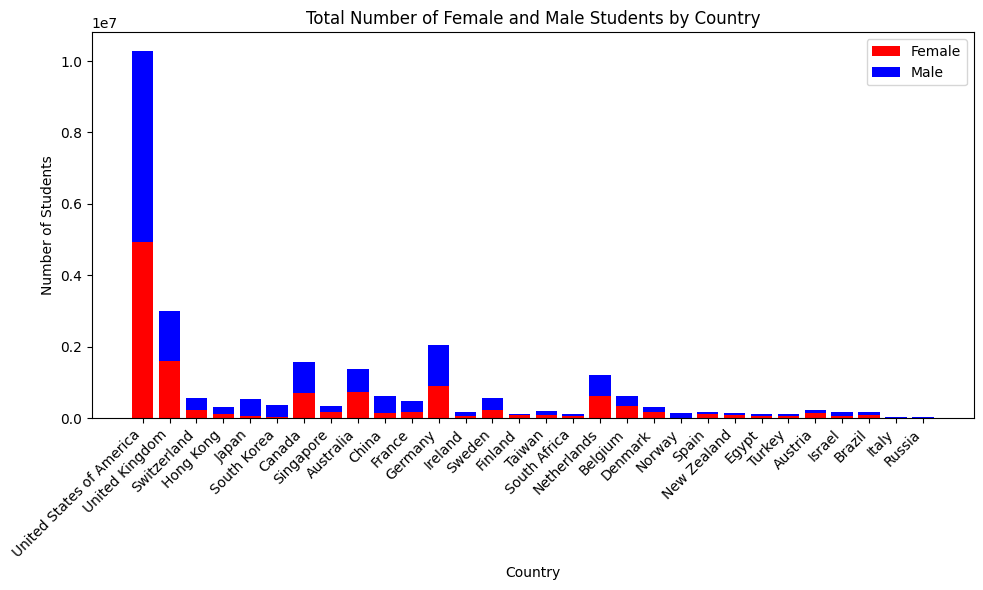

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('C:\\Users\\revan\\Desktop\\Ravan_Gasimzade_quiz\\female_male.csv')

plt.figure(figsize=(10, 6))
plt.bar(data['country_name'], data['total_female_students'], label='Female', color='red')
plt.bar(data['country_name'], data['total_male_students'], bottom=data['total_female_students'], label='Male', color='blue')

plt.xlabel('Country')
plt.ylabel('Number of Students')
plt.title('Total Number of Female and Male Students by Country')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


7. Find out total number of all students and all international students by each academic year:
a. Convert result set into CSV format and create Vertical or Horizontal Bar chart displaying total number of all students alongside with all international students by each academic year.

In [ ]:
-- 7. Find out total number of all students and all international students by each academic year:
-- a. Convert result set into CSV format and create Vertical or Horizontal Bar chart displaying total number of all students alongside with all international students by each academic year.

SELECT 
    year,
    SUM(num_students) AS total_students,
    SUM( ROUND(num_students * pct_international_students / 100) ) AS total_international_students
FROM 
    university_year
GROUP BY 
    year;

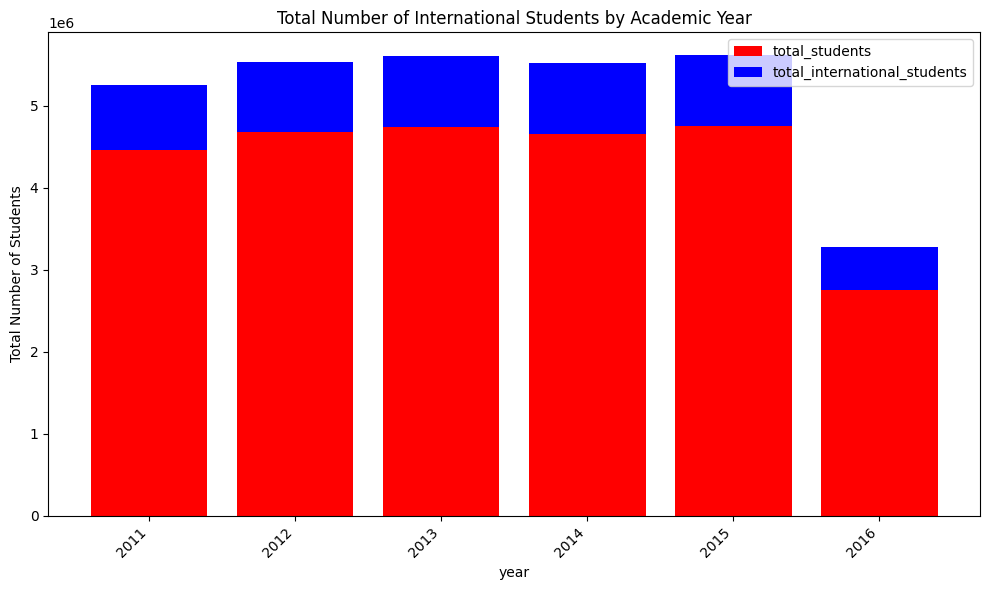

In [7]:


import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('C:\\Users\\revan\\Desktop\\Ravan_Gasimzade_quiz\\academicyear.csv') #, names=['year', 'total_students', 'total_international_students'])

plt.figure(figsize=(10, 6))
plt.bar(data['year'], data['total_students'], label='total_students', color='red')
plt.bar(data['year'], data['total_international_students'], bottom=data['total_students'], label='total_international_students', color='blue')

plt.xlabel('year')
plt.ylabel('Total Number of Students')
plt.title('Total Number of International Students by Academic Year')
plt.xticks(rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()



8. Using window functions, find out the first value and the last value of scores of each university and calculate progress of students (difference between first and last):
a. Display all results alongside university_name and year.

In [ ]:
-- 8. Using window functions, find out the first value and the last value of scores of each university and calculate progress of students (difference between first and last):
-- a. Display all results alongside university_name and year.
SELECT 
    u.university_name,
    yr.year,
    FIRST_VALUE(ur.score) OVER (PARTITION BY ur.university_id ORDER BY yr.year) AS first_score,
    LAST_VALUE(ur.score) OVER (PARTITION BY ur.university_id ORDER BY yr.year) AS last_score,
    LAST_VALUE(ur.score) OVER (PARTITION BY ur.university_id ORDER BY yr.year) - FIRST_VALUE(ur.score) OVER (PARTITION BY ur.university_id ORDER BY yr.year) AS progress
FROM
    university_ranking_year ur
JOIN
    university_year yr ON ur.university_id = yr.university_id AND ur.year = yr.year
JOIN
    university u ON ur.university_id = u.id;
GROUP BY 
    u.university_name;